In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import hashlib
import matplotlib
matplotlib.rc('font', size=15)

# Hexagon grid conversions

Define a tesselating hexagonal grid: a set of hexagons $\mathcal{H}$ covers the cartesian plane $\mathbb{R}^2$. Each hexagon $h_{i,j} \in \mathcal{H}$ has an integer address $\{i, j\} \in \mathbb{Z}^2$. Note of course that the hexagons do not overlap so that the intersection of any two distinct $h_{i,j}$ is null, and the cartesian space is covered such that any coordinate $\{x, y\} \in \mathbb{R}^2$ belongs to some $h_{i,j}$.

We can therefore define the grid with a function $f : \mathbb{R}^2 \rightarrow \mathbb{Z}^2$ that maps coordinates in cartesian space to the corresponding hexagon address. This function is useful in the context of a computer interaction where a user selects a pixel location on a rendering of the hexagonal grid, and we which to find the corresponding grid coordinates.

Without loss of generality, assume that the hex grid is "flat topped" as defined in [1], and the hexagonal grid coordinates are "Axial Coordinates" as defined in [1].

[1]: <https://www.redblobgames.com/grids/hexagons/>

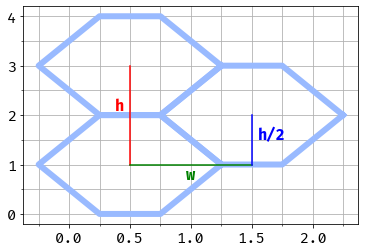

In [6]:
def hex_points():
    h=2
    w=1
    p=0.5
    return np.array([
        [w/4+p,0],
        [w/4, h/2],
        [-w/4, h/2],
        [-w/4-p, 0],
        [-w/4, -h/2],
        [w/4, -h/2],
        [w/4+p,0]
    ])

points = (hex_points() + [0.5, 1])
hex_color='#99baff'
plt.plot(*points.transpose(), lw=6, color=hex_color)
plt.plot(*(points + [1, 1]).transpose(), lw=6, color=hex_color)
plt.plot(*(points + [0, 2]).transpose(), lw=6, color=hex_color)
plt.grid(which='both')
ax = plt.gca()
ax.set_xticks(np.arange(-0.25, 2.26, 0.25), minor=True)
ax.set_yticks(np.arange(-0, 4.1, 0.5), minor=True)
plt.plot([0.5, 0.5], [1, 3], color='red')
plt.annotate('h', [0.5, 2.5], [0.45, 2.1], horizontalalignment='right', color='red', weight='bold')

plt.plot([0.5, 1.5], [1, 1], color='green')
plt.annotate('w', [0.7, 0.7], [1, 0.7], horizontalalignment='center', color='green', weight='bold')

plt.plot([1.5, 1.5], [1, 2], color='blue')
plt.annotate(r'h/2', [1.5, 1.5], [1.55,1.5], horizontalalignment='left', color='blue', weight='bold')

None

In [3]:
def color_for_hex(i, j):
    hash_data = hashlib.sha256(f'{int(i), int(j)}'.encode()).digest()
    return np.frombuffer(hash_data, dtype=np.uint8)[:12:4].astype(float)/255

In [72]:
x_values = np.linspace(0,7,200)
y_values = np.linspace(0,14,200)

In [74]:
def world_to_axial(x, y):
    world = np.array([x,(y-np.floor(x))/2])
    bottom_left = np.floor(world)
    local = world-bottom_left
    
    if np.sum([local[0], local[1]]) < 0.25:
        move = (-1, -1)
    elif np.sum([local[0], 1-local[1]]) < 0.25:
        move = (-1, 0)
    elif np.sum([1-local[0], 1-local[1]]) < 0.25:
        move = (1, 1)
    elif np.sum([1-local[0], local[1]]) < 0.25:
        move = (1, 0)
    else:
        move = (0, 0)
        
    i = np.int(np.floor(x))
    j = np.int(np.floor((y-i%2)/2)) + (i+1)//2
    return (i + move[0],j + move[1])


In [82]:
img_rgba = np.zeros((img[0].shape[0], img[0].shape[1], 3), dtype=np.float)
for j, y in enumerate(y_values):
    for i, x in enumerate(x_values):
        img_rgba[j, i, :] = color_for_hex(*world_to_axial(x,y))

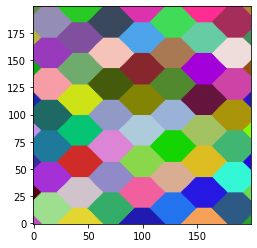

In [84]:
plt.imshow(img_rgba, origin='lower')

In [113]:
x=0.25
y=0
h=2
w=1
p=0.5
points = np.array([
    [w/4+p,0],
    [w/4, h/2],
    [-w/4, h/2],
    [-w/4-p, 0],
    [-w/4, -h/2],
    [w/4, -h/2],
    [w/4+p,0]
])+np.array([x+w/2,y+h/2])
for p in points:
    print(f'<line x="{p[0]}" y="{p[1]}"/>')

<line x="1.5" y="1.0"/>
<line x="1.0" y="2.0"/>
<line x="0.5" y="2.0"/>
<line x="0.0" y="1.0"/>
<line x="0.5" y="0.0"/>
<line x="1.0" y="0.0"/>
<line x="1.5" y="1.0"/>


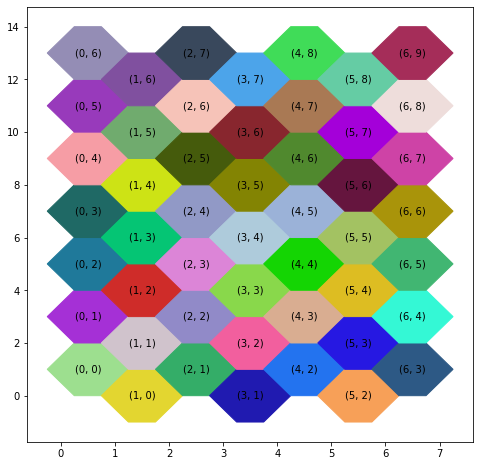

In [108]:
def color_for_hex(i, j):
    hash_data = hashlib.sha256(f'{int(i), int(j)}'.encode()).digest()
    return np.frombuffer(hash_data, dtype=np.uint8)[:12:4].astype(float)/255

def plot_hex(ax, i, j):
    x, y = axial_to_world(i, j)
    color = color_for_hex(i, j)
    points = hex_points()+np.array([x+w/2,y+h/2])
    ax.fill(*points.transpose(), color=color)
    
    
def axial_to_world(i, j):
    x = np.float(i)
    y = np.float(2*j + i%2 - 2*((i+1)//2))
    return x,y
    
fig = plt.figure(figsize=(8,8))
ax = plt.subplot()

for i in range(0, 7):
    for j in range(0, 7):
        j = j + i//2
        plot_hex(ax, i, j)
        ax.annotate(f'{i, j}', (x+w/2, y+h/2), horizontalalignment='center', verticalalignment='center')
    



In [63]:
h=np.cos(np.deg2rad(30))
p=np.sin(np.deg2rad(30))
w = (1-p)

In [66]:
world_to_axial(0.0,2.0)

array([-1, 0], dtype=object)

In [69]:
axial_to_world(0, 0)

(0.0, 0.0)

In [70]:
world_to_axial(0, 0)

array([-1, -1], dtype=object)

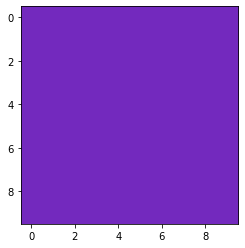

In [338]:
plt.imshow([[value_as_color(0,0)]*10]*10)

In [38]:
np.frombuffer(hash.digest(), dtype=np.uint8)

array([ 23, 248, 175, 151, 173,  74, 127, 118,  57, 164, 201,  23,  29,
        81, 133, 203, 175, 184,  84,  98, 135, 122,  71,  70, 194,  27,
       219,  10,  79, 148,  12, 160], dtype=uint8)